# Run Sandwich Attacks on Swaps from the Public Mempool

In [1]:
%load_ext autoreload
%autoreload 2

In [49]:
import os
import sys
import math

current_path = sys.path[0]
sys.path.append(
    current_path[: current_path.find("defi-measurement")]
    + "liquidity-distribution-history"
)

sys.path.append("..")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from datetime import datetime, timezone


# Set display options
pd.set_option('display.max_colwidth', None)  # Display entire cell content
pd.set_option('display.max_rows', 50)    # Display all rows
pd.set_option('display.max_columns', None) # Display all columns


import psycopg2
import sqlalchemy
from dotenv import load_dotenv
from matplotlib.ticker import MaxNLocator
from pool_state import v3Pool
from sqlalchemy import create_engine
from tqdm import tqdm
from collections import deque

load_dotenv(override=True)
# from experiments.random_permutations import load_pool

from experiments.preload_pool_cache import load_pool_from_blob


from decimal import getcontext

getcontext().prec = 100  # Set the precision high enough for our purposes


# Read in the environment variables
postgres_uri_mp = os.environ["POSTGRESQL_URI_MP"]
postgres_uri_us = os.environ["POSTGRESQL_URI_US"]
azure_storage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]


## Get the Data

In [3]:
engine = create_engine(postgres_uri_mp)

query = """
SELECT *
FROM SWAP_LIMIT_PRICE AS LIM
INNER JOIN MEMPOOL_TRANSACTIONS AS MEM ON LIM.transaction_hash = MEM.HASH
"""

# col_rename = dict(
#     call_block_number='block_number',
#     contract_address='pool',
# )

# df = pd.read_sql_query(query, engine).rename(columns=col_rename).sort_values(by=['pool', 'block_number'])
df = pd.read_sql_query(query, engine)

df

,transaction_type,transaction_hash,recipient,amountIn,amountOut,amountOutMin,amountInMax,payerIsUser,token0,fee,token1,pool,hash,first_seen
0,V3_SWAP_EXACT_IN,0xf994fffef07171ffd55740b211588979d8745a964f24b1c137fa2cd5874536a2,0x0000000000000000000000000000000000000001,2300000000000000000,None,20720352176690778061354,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0x046eee2cc3188071c02bfc1745a6b17c656e3f3d,0x510100d5143e011db24e2aa38abe85d73d5b2177,0xf994fffef07171ffd55740b211588979d8745a964f24b1c137fa2cd5874536a2,2023-08-11 18:39:57.688000+00:00
1,V3_SWAP_EXACT_IN,0x68e616c69d7fc23d8669221616130baee931bb438d4aa8a686d88d390cda5323,0x0000000000000000000000000000000000000001,220000000000000000,None,1939764922511645684352,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0x046eee2cc3188071c02bfc1745a6b17c656e3f3d,0x510100d5143e011db24e2aa38abe85d73d5b2177,0x68e616c69d7fc23d8669221616130baee931bb438d4aa8a686d88d390cda5323,2023-08-11 18:36:06.730000+00:00
2,V3_SWAP_EXACT_IN,0x4f5aa8d66ab6404c628dd498979489cb173df77ed8078edf736e183d41e82dae,0x0000000000000000000000000000000000000001,300000000000000000,None,2686021351206594973990,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0x046eee2cc3188071c02bfc1745a6b17c656e3f3d,0x510100d5143e011db24e2aa38abe85d73d5b2177,0x4f5aa8d66ab6404c628dd498979489cb173df77ed8078edf736e183d41e82dae,2023-08-11 18:35:33.257000+00:00
3,V3_SWAP_EXACT_IN,0xbdbebc9d69e98aef757fc1c24ea1cf9f513f9aba3484749f070124fabf674256,0x0000000000000000000000000000000000000002,2500000000000000000000,None,270568229649369198,None,true,0x046eee2cc3188071c02bfc1745a6b17c656e3f3d,3000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x510100d5143e011db24e2aa38abe85d73d5b2177,0xbdbebc9d69e98aef757fc1c24ea1cf9f513f9aba3484749f070124fabf674256,2023-08-11 18:30:36.115000+00:00
4,V3_SWAP_EXACT_IN,0x7b78d768aa6cfe6f56b1fbbee88190ebe2916a37d6b9044476945d773fa24e89,0x0000000000000000000000000000000000000001,110000000000000000,None,973957923669322643285,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0x046eee2cc3188071c02bfc1745a6b17c656e3f3d,0x510100d5143e011db24e2aa38abe85d73d5b2177,0x7b78d768aa6cfe6f56b1fbbee88190ebe2916a37d6b9044476945d773fa24e89,2023-08-11 18:29:20.280000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34304,V3_SWAP_EXACT_IN,0xf6f3de23aa19144a456cd8c8812b2dbe7390a80482e903991e025eec1e874f3a,0x0000000000000000000000000000000000000002,757397629026218297029,None,38646185738092907,None,true,0xc5bcc8ba3f33ab0d64f3473e861bdc0685b19ef5,10000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xfde61ea5a1c8827f0c83e1b3c05a3cdefed8a8db,0xf6f3de23aa19144a456cd8c8812b2dbe7390a80482e903991e025eec1e874f3a,2023-08-05 00:21:11.999000+00:00
34305,V3_SWAP_EXACT_IN,0xaf0949be9fbd4268d7bb28322ef46c40911ee352aaafd77592a2d7c7a3deaa41,0x0000000000000000000000000000000000000002,14186295104880139128246102,None,472650797817056376,None,true,0x8cf8e9e63c3f39eb97a1e8020397bda93cc07196,10000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x37dfe3f7c42bd62509d6d31a53aed18805a34369,0xaf0949be9fbd4268d7bb28322ef46c40911ee352aaafd77592a2d7c7a3deaa41,2023-08-04 23:55:23.945000+00:00
34306,V3_SWAP_EXACT_IN,0x9813cb62b75b03395c67ff919277825581b10fd0dcb877a55c72d34202a60089,0x0000000000000000000000000000000000000001,2500000000000000,None,417998905226446063984,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0x001a8ffcb0f03e99141652ebcdecdb0384e3bd6c,0xf766436b551d2acb09b73d126fd49869541dfa26,0x9813cb62b75b03395c67ff919277825581b10fd0dcb877a55c72d34202a60089,2023-08-04 23:38:32.946000+00:00
34307,V3_SWAP_EXACT_IN,0xf4c22504de2e141335421b728ff015bf11c9f3b677e32d53bfbce32d8eb5a980,0x0000000000000000000000000000000000000002,836623000000000000000000,None,68460438323977550,None,true,0x24ae124c4cc33d6791f8e8b63520ed7107ac8b3e,3000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xd2ef54450ec52347bde3dab7b086bf2a005601d8,0xf4c22504de2e141335421b728ff015bf11c9f3b677e32d53bfbce32d8eb5a980,2023-08-04 23:33:38.843000+00

### Populate the swap data we have with the block number that the swap appeared in

In [4]:
engine = create_engine(postgres_uri_us)

block_numbers = pd.read_sql_query(
    """
    SELECT block_number, tx_hash, block_ts
    FROM swaps
    WHERE block_number >= 17400000
    ORDER BY block_ts ASC
    """,
    engine
).set_index('tx_hash')

block_numbers

,block_number,block_ts
tx_hash,,
0x5ab1506abd1525fe09bb7243c0bfa3fc9a40a16fb3bfeb3ecb346863d3c5b887,17400000,2023-06-03 11:56:35
0x975564e0b0cf3595616486b015bb7e755bae1bc403204dfbda6cda8bfe0b2cce,17400000,2023-06-03 11:56:35
0xafc7a3ea2f36db267f26615eb2b94308c3225f819986073cfee134aff16692a2,17400000,2023-06-03 11:56:35
0x9aed05c2942cdba44b864cd5384fc0f97d93311857f4fb7b9407c60958fbf04a,17400000,2023-06-03 11:56:35
0xd833f22ec0ec84a13255b3f400809177535c2412af161386d937a02d5160eb1a,17400001,2023-06-03 11:56:47
...,...,...
0x5db7b2f10a6aae5f3ba7943c59f005e1f8757004dc73b77d9585d50d8d273339,17864000,2023-08-07 15:39:23
0xbece543508c1e11c51b3bd2dfaae0b1e196ff5151bbc49b794bd293126a3bd34,17864000,2023-08-07 15:39:23
0xe9f87658524a4529c06e9157822725469b36157624b74012716d6f2144b83762,17864005,2023-08-07 15:40:23


In [5]:
block_number_dict = block_numbers[~block_numbers.index.duplicated(keep='first')].to_dict(orient="index")

In [6]:
dataset = df.assign(block_number=df.transaction_hash.map(lambda x: block_number_dict[x]['block_number'] if x in block_number_dict else None))
dataset = dataset[~dataset.block_number.isna()]

dataset


,transaction_type,transaction_hash,recipient,amountIn,amountOut,amountOutMin,amountInMax,payerIsUser,token0,fee,token1,pool,hash,first_seen,block_number
16631,V3_SWAP_EXACT_IN,0xa0a5afcd657dab417f6004441f047b081c9ea47d4d5c5261e5c70fd96227e86c,0x0000000000000000000000000000000000000002,27500000,None,14279146475339860,None,true,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,3000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xa0a5afcd657dab417f6004441f047b081c9ea47d4d5c5261e5c70fd96227e86c,2023-08-05 14:55:51.071000+00:00,17849502.0
16640,V3_SWAP_EXACT_IN,0xbd4ed3c7f0cbe37beaab4af01f621cec8e8472850bfd1a6444d3e83263efa299,0x0000000000000000000000000000000000000002,302990056,None,163158812849422667,None,true,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,3000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xbd4ed3c7f0cbe37beaab4af01f621cec8e8472850bfd1a6444d3e83263efa299,2023-08-05 14:30:15.858000+00:00,17849374.0
16646,V3_SWAP_EXACT_IN,0x0815280508f43c94e4a0a2991f24108124effac762c120022b9e66febbe88696,0x0000000000000000000000000000000000000002,5273000000,None,2882045483002369817,None,true,0xdac17f958d2ee523a2206206994597c13d831ec7,500,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x11b815efb8f581194ae79006d24e0d814b7697f6,0x0815280508f43c94e4a0a2991f24108124effac762c120022b9e66febbe88696,2023-08-07 15:42:20.173000+00:00,17864015.0
16650,V3_SWAP_EXACT_IN,0xd6b7f04b0a02f7542805b954985ea9020dcfd98972a840081f4ee29b8506d9b7,0x0000000000000000000000000000000000000001,10000000000000000000,None,18155266696,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,500,0xdac17f958d2ee523a2206206994597c13d831ec7,0x11b815efb8f581194ae79006d24e0d814b7697f6,0xd6b7f04b0a02f7542805b954985ea9020dcfd98972a840081f4ee29b8506d9b7,2023-08-07 15:38:29.967000+00:00,17863996.0
16671,V3_SWAP_EXACT_IN,0xec263f9c66d81cb1970f671a1c6d907d3349f59a6de8d5c1454356f3997ece05,0x0000000000000000000000000000000000000001,300000000000000000,None,537970208,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,500,0xdac17f958d2ee523a2206206994597c13d831ec7,0x11b815efb8f581194ae79006d24e0d814b7697f6,0xec263f9c66d81cb1970f671a1c6d907d3349f59a6de8d5c1454356f3997ece05,2023-08-07 15:11:52.821000+00:00,17863865.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34257,V3_SWAP_EXACT_IN,0xe37078bcf2dc0786a85a74d9932d4cb32e072e415bcba918dcd7fe0b8815ec08,0x0000000000000000000000000000000000000001,70000000000000,None,1179619575207962334,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,10000,0xc944e90c64b2c07662a292be6244bdf05cda44a7,0x46add4b3f80672989b9a1eaf62cad5206f5e2164,0xe37078bcf2dc0786a85a74d9932d4cb32e072e415bcba918dcd7fe0b8815ec08,2023-08-05 08:21:32.150000+00:00,17847544.0
34267,V3_SWAP_EXACT_IN,0x3bcb9fe41868c827f338bfe6cce093c3e4b7f7c5b25fb986e1f9bd426d69010c,0x0000000000000000000000000000000000000001,31459982815039388609469,None,88173105,None,true,0x88303fed02b31db9c7a9eafb711da9ef4a03e5d3,3000,0xdac17f958d2ee523a2206206994597c13d831ec7,0xac5d39a35295392eada009e84ae0889d5b69bed0,0x3bcb9fe41868c827f338bfe6cce093c3e4b7f7c5b25fb986e1f9bd426d69010c,2023-08-05 08:11:58.399000+00:00,17847496.0
34289,V3_SWAP_EXACT_IN,0x0236f2774357c8ec52e086e6516476bc5d0decaf73eaa64d3a9aa0bdef084bdb,0x0000000000000000000000000000000000000002,107230444337841327371496,None,44726990681162797,None,true,0x7f3edcdd180dbe4819bd98fee8929b5cedb3adeb,10000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xa83326d20b7003bcecf1f4684a2fbb56161e2a8e,0x0236f2774357c8ec52e086e6516476bc5d0decaf73eaa64d3a9aa0bdef084bdb,2023-08-05 06:46:59.090000+00:00,17847076.0
34291,V3_SWAP_EXACT_IN,0xb3f0775718280ce98d348ce325265c37f76a95efe9a1929a141974c2a413d98c,0x0000000000000000000000000000000000000001,96000000000000000,None,228281960750463185299147,None,false,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,10000,0x7f3edcdd180dbe4819bd98fee8929b5cedb3adeb,0xa83326d20b7003bcecf1f4684a2fbb56161e2a8e,0xb3f0775718280ce98d348ce325265c37f76a95efe9a1929a

In [7]:
swap_counts = dataset.groupby(by=['pool', 'block_number'])[['transaction_hash']].count().sort_values('transaction_hash', ascending=False)

swap_counts[swap_counts == 1].transaction_hash.sum(), swap_counts[swap_counts > 1].transaction_hash.sum(), swap_counts.transaction_hash.sum()

(1115.0, 8.0, 1123)

## Create Sandwich Attacks on Single Swaps

Start with this to validate the approach.

In [8]:
single_swap_blocks = swap_counts[swap_counts == 1].sort_index()

df_single = dataset.set_index(['pool', 'block_number']).loc[single_swap_blocks.index]

# Group by level 0 and count unique values in level 1
grouped_counts = df_single.groupby(level=0).apply(lambda x: x.index.get_level_values(1).nunique())

# Sort the indices based on the counts
sorted_indices = grouped_counts.sort_values(ascending=False).index

# Reindex the DataFrame based on this sorted order
df_single_sorted = df_single.loc[sorted_indices]


df_single_sorted

transaction_type  \
pool                                       block_number                     
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17844881.0    V3_SWAP_EXACT_IN   
                                           17844904.0    V3_SWAP_EXACT_IN   
                                           17845667.0    V3_SWAP_EXACT_IN   
                                           17845763.0    V3_SWAP_EXACT_IN   
                                           17845997.0    V3_SWAP_EXACT_IN   
...                                                                   ...   
0x824a30f2984f9013f2c8d0a29c0a3cc5fd5c0673 17851468.0    V3_SWAP_EXACT_IN   
0x2519042aa735edb4688a8376d69d4bb69431206c 17860223.0    V3_SWAP_EXACT_IN   
0x84383fb05f610222430f69727aa638f8fdbf5cc1 17860950.0    V3_SWAP_EXACT_IN   
0x8592064903ef23d34e4d5aaaed40abf6d96af186 17861372.0    V3_SWAP_EXACT_IN   
0x0188c28ea32d7860334be1a8068cfbadce18f1d9 17853849.0    V3_SWAP_EXACT_IN   

                                                                                                           transaction_hash  \
pool                                       block_number                                                                       
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17844881.0    0x9b725af94aeee29b275de52f7c24daa0eae7e5307005c658c5f34899035d89ee   
                                           17844904.0    0x14b5685befba09b42d2fe0f6cc7c2b0c3fd0764355f2e1fe908dd132aa324e4d   
                                           17845667.0    0xe2a288a88564e946aa9bf295d2356d3845fc48d42732710f91c2449f81cd3798   
                                           17845763.0    0xd8b8bbc709e03d77db68563fd16abd9caaf3b8d851a4c6e50ac597582788b9e2   
                                           17845997.0    0xb993834ce53cc8cec95ef92af13a3ac04dedf4cd9c954bc0ce708e78ca98f7ad   
...                                                                                                                     ...   
0x824a30f2984f9013f2c8d0a29c0a3cc5fd5c0673 17851468.0    0x470622c876dc89d5fa0dfde9cf9fe6633ceaa3085393527c1ab8d2dcbeed3c1d   
0x2519042aa735edb4688a8376d69d4bb69431206c 17860223.0    0xa79792dbe256b736e0e7bee05c5396a8f35914fc9591f3f64ee580ebaaf9cdf8   
0x84383fb05f610222430f69727aa638f8fdbf5cc1 17860950.0    0x7315d085c6e0eabe2fd192d778ad55dc84dbd436eb6d8ca919a57a3f0f619777   
0x8592064903ef23d34e4d5aaaed40abf6d96af186 17861372.0    0x99569ef3912b419a6e779951d696f82f714f7f6469e2a4613822580739f37f37   
0x0188c28ea32d7860334be1a8068cfbadce18f1d9 17853849.0    0x4f7dea75e57c80506fd03dfb35edfce4ed1a67a773e84cff7e515bd915b29053   

                                                                                          recipient  \
pool                                       block_number                                               
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17844881.0    0x0000000000000000000000000000000000000001   
                                           17844904.0    0x0000000000000000000000000000000000000001   
                                           17845667.0    0x0000000000000000000000000000000000000002   
                                           17845763.0    0xa8f308ab910027c5245dcfb9a5eca02444a35499   
                                           17845997.0    0x0000000000000000000000000000000000000001   
...                                                                                             ...   
0x824a30f2984f9013f2c8d0a29c0a3cc5fd5c0673 17851468.0    0x0000000000000000000000000000000000000002   
0x2519042aa735edb4688a8376d69d4bb69431206c 17860223.0    0x0000000000000000000000000000000000000002   
0x84383fb05f610222430f69727aa638f8fdbf5cc1 17860950.0    0x0000000000000000000000000000000000000001   
0x8592064903ef23d34e4d5aaaed40abf6d96af186 17861372.0    0x0000000000000000000000000000000000000001   
0x0188c28ea32d7860334be1a8068cfbadce18f1d9 17853849.0    0x0000000000000000000000000000000000000001   

                                                               

In [9]:
# Keep only the swap in subset for now
df_single_sorted = df_single_sorted[df_single_sorted.transaction_type == 'V3_SWAP_EXACT_IN'].drop(columns=['transaction_type', 'recipient', 'amountOut', 'amountInMax', 'payerIsUser', 'transaction_hash'])

In [10]:
# Focus on ETH/USDC for now
df_single_sorted = df_single_sorted[df_single_sorted.index.get_level_values(0) == '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640']

# Focus on swaps where ETH is input
df_single_sorted = df_single_sorted[df_single_sorted.token0 == '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2']

df_single_sorted = df_single_sorted[df_single_sorted.amountIn != '57896044618658097711785492504343953926634992332820282019728792003956564819968']

df_single_sorted = df_single_sorted.assign(eth_in_float=df_single_sorted.amountIn.apply(lambda x: int(x) / 1e18))

df_single_sorted = df_single_sorted.sort_values(by=['eth_in_float'], ascending=False)

df_single_sorted

amountIn  \
pool                                       block_number                         
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17849012.0    16530000000000000000   
                                           17844904.0    13000000000000000000   
                                           17863461.0    10000000000000000000   
                                           17856593.0     9000000000000000000   
                                           17848870.0     8250000000000000000   
                                           17857500.0     6744585716574447597   
                                           17857679.0     3602008804160356819   
                                           17853735.0     2603925444272318247   
                                           17858489.0     1950450408149760738   
                                           17850902.0     1823681000000000000   
                                           17858460.0     1700000000000000000   
                                           17848777.0     1450000000000000000   
                                           17860868.0     1249807486624961355   
                                           17857013.0     1150000000000000000   
                                           17862801.0     1000000000000000000   
                                           17863555.0     1000000000000000000   
                                           17849041.0      900000000000000000   
                                           17844881.0      820000000000000000   
                                           17862578.0      780000000000000000   
                                           17855772.0      500000000000000000   
                                           17852382.0      500000000000000000   
                                           17862820.0      500000000000000000   
                                           17849968.0      400000000000000000   
                                           17850543.0      400000000000000000   
                                           17861025.0      269000000000000000   
                                           17854678.0      220000000000000000   
                                           17850444.0      216000000000000000   
                                           17861104.0      170000000000000000   
                                           17846376.0      160000000000000000   
                                           17862051.0      150000000000000000   
                                           17856635.0      144000000000000000   
                                           17852486.0      135875000000000000   
                                           17853497.0      100000000000000000   
                                           17860189.0      100000000000000000   
                                           17850263.0       75000000000000000   
                                           17850763.0       55423625995265382   
                                           17857202.0       19500000000000000   
                                           17859591.0       15000000000000000   
                                           17855641.0       10000000000000000   
                                           17849054.0        5000000000000000   
                                           17845997.0        3000000000000000   
                                           17853087.0        1000000000000000   

                                                        amountOutMin  \
pool                                       block_number                
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17849012.0    29920471710   
                                           17844904.0    23596354509   
                                           17863461.0    18177298747   
                                           17856593.0    16359170838   
                                           17848870.0    14785625076   


In [11]:
pools_ordered = df_single_sorted.index.get_level_values('pool').unique()

pools_ordered[:5]

Index(['0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640'], dtype='object', name='pool')

## Get a pool and do some initial testing

In [12]:
def to_price(inv_sqrt_price):
    return 1/(inv_sqrt_price)**2 * 1e12

In [13]:
pool: v3Pool = load_pool_from_blob(
    "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640",
    postgres_uri_us,
    azure_storage_uri,
    "uniswap-v3-pool-cache",
    verbose=True,
    invalidate_before_date=datetime(2023, 8, 15, tzinfo=timezone.utc),
)

Blob is invalidated due to old modification date
Loading pool from database


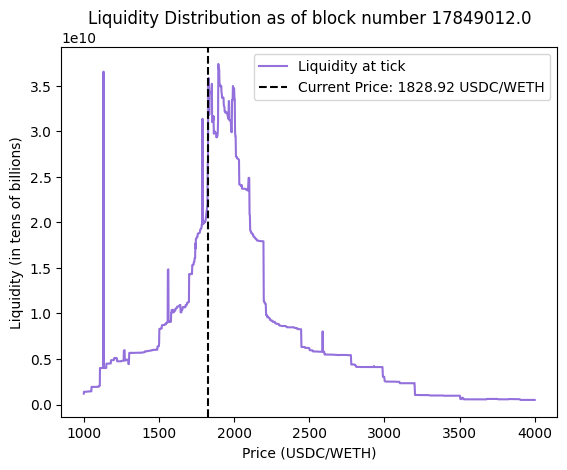

In [22]:
########### INPUT BLOCK ###############
block_number          = 17849012.0
transaction_index     = 0
display_price_lower   = 1000
display_price_upper   = 4000

#######################################
def plot_liq(pool, block_number, transaction_index, display_price_lower, display_price_upper):
    as_of = block_number + transaction_index / 1e4
    x, y = pool.createLiq(as_of)
    x, y = np.array(x), np.array(y)
    px = pool.getPriceAt(as_of)
    liq_df = pd.DataFrame(x, columns=["ticks"])
    liq_df["liquidity"] = y
    liq_df['px'] = 1 / (1.0001 ** liq_df['ticks']) * 1e12

    plot_df = liq_df[(liq_df['px'] < display_price_upper) & (liq_df['px'] > display_price_lower)].set_index("px")

    fig, ax = plt.subplots()

    ax.plot(plot_df['liquidity'], label = "Liquidity at tick", color = 'mediumpurple')
    
    curr_price = (1 / px ** 2) * 1e12
    ax.axvline(curr_price, color='black', linestyle = "--", label=f"Current Price: {curr_price:.2f} USDC/WETH")
    ax.legend()
    ax.set_ylabel("Liquidity (in tens of billions)")
    ax.set_xlabel("Price (USDC/WETH)")
    ax.set_title(f'Liquidity Distribution as of block number {as_of}')

    plt.show()

plot_liq(pool, block_number, transaction_index, display_price_lower, display_price_upper)

In [23]:
orig_fee = pool.fee

orig_fee

0.0005

In [62]:
# pool.fee = orig_fee
pool.fee = 0

In [17]:
from dataclasses import dataclass
from datetime import datetime
from typing import Union

@dataclass
class SwapData:
    pool: str
    block_number: float
    amountIn: str
    amountOutMin: str
    token0: str
    fee: str
    token1: str
    hash: str
    first_seen: Union[datetime, None]
    eth_in_float: float


In [58]:
def valid_frontrun(pool: v3Pool, swap: SwapData, frontrun_input) -> bool:

    curr_price = pool.getPriceAt(swap.block_number)

    swap_params = {
        "input": frontrun_input,
        "tokenIn": swap.token0,
        "as_of": swap.block_number,
        "gasFee": True,
        "givenPrice": curr_price,
    }

    _, heur = pool.swapIn(swap_params)

    swap_params = {
        "input": int(swap.amountIn),
        "tokenIn": swap.token0,
        "as_of": swap.block_number,
        "gasFee": True,
        "givenPrice": heur.sqrtP_next,
    }

    output, heur = pool.swapIn(swap_params)

    return output >= int(swap.amountOutMin)


def exponential_search(pool: v3Pool, swap: SwapData, start=1e6, max_tries=100, factor=8) -> (int, int):
    lower = 0
    upper = start
    
    for i in range(max_tries):
        print(f"{i}: Trying {upper / 1e18}")
        if not valid_frontrun(pool, swap, upper):
            return lower, upper
        else:
            lower = upper
            upper *= factor

    else:
        raise Exception("Exponential search exceeded max tries")
    
def binary_search(pool: v3Pool, swap: SwapData, lower, upper, max_tries=100) -> int:
    for i in range(max_tries):
        print(f"{i}: Trying {lower / 1e18} - {upper / 1e18}")
        if math.isclose(lower, upper, abs_tol=1e18):
            return lower
        
        mid = (lower + upper) // 2
        if valid_frontrun(pool, swap, mid):
            lower = mid
        else:
            upper = mid

    else:
        raise Exception("Binary search exceeded max tries")
    

def max_frontrun(pool: v3Pool, swap: SwapData, start=1e6) -> int:
    lower, upper = exponential_search(pool, swap, start=start)
    return binary_search(pool, swap, lower, upper)
    

In [64]:
assert pool is not None
row = df_single_sorted.iloc[0:10, :]

swap = SwapData(**row.reset_index().to_dict(orient='records')[0])

In [65]:
print(f"Pool: {swap.pool}, Block: {swap.block_number}")

# Insert a frontrunning attack first
curr_price = pool.getPriceAt(swap.block_number)


print("Doing frontrun")
print(f"Start Price: {curr_price} ({to_price(curr_price)})")

print("Finding frontrun input")
frontrun_input = max_frontrun(pool, swap, start=1e19)

swap_params = {
    "input": frontrun_input,
    "tokenIn": swap.token0,
    "as_of": swap.block_number,
    "gasFee": True,
    "givenPrice": curr_price,
}

output_frontrun, heur = pool.swapIn(swap_params)

print(f"Put in {frontrun_input / 1e18} ETH and got out {output_frontrun / 1e6} USDC, i.e., price of {(output_frontrun / frontrun_input) * 1e12} USDC/ETH")

print(f"price after frontrun: {heur.sqrtP_next} ({to_price(heur.sqrtP_next)})")
print(f"Min price {(int(swap.amountIn) / int(swap.amountOutMin))**0.5} ({to_price((int(swap.amountIn) / int(swap.amountOutMin))**0.5)})")

print("Doing user swap")
print(f"Trying to swap in {int(swap.amountIn) / 1e18}")

swap_params = {
    "input": int(swap.amountIn),
    "tokenIn": swap.token0,
    "as_of": swap.block_number,
    "gasFee": True,
    "givenPrice": heur.sqrtP_next,
}

output, heur = pool.swapIn(swap_params)
print(f"price after user swap: {heur.sqrtP_next} ({to_price(heur.sqrtP_next)})")

print(f"Swap ({swap.amountIn} for {output}) Max price {(int(swap.amountIn) / int(swap.amountOutMin))**0.5}")
print(f"Output: {output} vs. minimum out: {swap.amountOutMin}, valid: {output >= int(swap.amountOutMin)}")
print(f"Sqrt Price and next: {heur.sqrt_P}, {heur.sqrtP_next}")

print("Doing backrun")

swap_params = {
    "input": output_frontrun,
    "tokenIn": swap.token1,
    "as_of": swap.block_number,
    "gasFee": True,
    "givenPrice": heur.sqrtP_next,
}

output, heur = pool.swapIn(swap_params)

print(f"price after backrun: {heur.sqrtP_next} ({to_price(heur.sqrtP_next)})")
print(f"Put in {output_frontrun / 1e6} USDC and got out {output / 1e18} ETH, i.e., price of {(output_frontrun / output) * 1e12} USDC/ETH")
print(f"Put in {frontrun_input / 1e18} ETH in frontrun and got out {output / 1e18} ETH after backrun, diff of {(output-frontrun_input) / 1e18}")


Pool: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640, Block: 17849012.0
Doing frontrun
Start Price: 23383.147161691497 (1828.917326173608)
Finding frontrun input
0: Trying 10.0
1: Trying 80.0
2: Trying 640.0
3: Trying 5120.0
0: Trying 640.0 - 5120.0
1: Trying 2880.0 - 5120.0
2: Trying 2880.0 - 4000.0
3: Trying 2880.0 - 3440.0
4: Trying 2880.0 - 3160.0
5: Trying 2880.0 - 3020.0
6: Trying 2880.0 - 2950.0
7: Trying 2915.0000000000005 - 2950.0
8: Trying 2932.5 - 2950.0
9: Trying 2932.5 - 2941.25
10: Trying 2936.875 - 2941.25
11: Trying 2936.875 - 2939.0625
12: Trying 2936.875 - 2937.96875
13: Trying 2936.875 - 2937.421875
Put in 2936.875 ETH and got out 5346425.790745 USDC, i.e., price of 1820.4471728435838 USDC/ETH
price after frontrun: 23504.143143391422 (1810.1357814018152)
Min price 23504.564493667407 (1810.0708838475498)
Doing user swap
Trying to swap in 16.53
price after user swap: 23504.954867909397 (1810.0107604237446)
Swap (16530000000000000000 for 29920511150) Max price 23504.5644936

In [ ]:
def get_mev_single(pool: v3Pool, swap: SwapData):
    print(f"Pool: {swap.pool}, Block: {swap.block_number}")

    # Insert a frontrunning attack first
    curr_price = pool.getPriceAt(swap.block_number)

    print("Doing frontrun")
    print(f"Start Price: {curr_price} ({to_price(curr_price)})")

    print("Finding frontrun input")
    frontrun_input = max_frontrun(pool, swap, start=1e20)

    swap_params = {
        "input": frontrun_input,
        "tokenIn": swap.token0,
        "as_of": swap.block_number,
        "gasFee": True,
        "givenPrice": curr_price,
    }

    output_frontrun, heur = pool.swapIn(swap_params)

    print(f"Put in {frontrun_input / 1e18} ETH and got out {output_frontrun / 1e6} USDC, i.e., price of {(output_frontrun / frontrun_input) * 1e12} USDC/ETH")

    print(f"price after frontrun: {heur.sqrtP_next} ({to_price(heur.sqrtP_next)})")
    print(f"Min price {(int(swap.amountIn) / int(swap.amountOutMin))**0.5} ({to_price((int(swap.amountIn) / int(swap.amountOutMin))**0.5)})")

    print("Doing user swap")
    print(f"Trying to swap in {int(swap.amountIn) / 1e18}")

    swap_params = {
        "input": int(swap.amountIn),
        "tokenIn": swap.token0,
        "as_of": swap.block_number,
        "gasFee": True,
        "givenPrice": heur.sqrtP_next,
    }

    output, heur = pool.swapIn(swap_params)
    print(f"price after user swap: {heur.sqrtP_next} ({to_price(heur.sqrtP_next)})")

    print(f"Swap ({swap.amountIn} for {output}) Max price {(int(swap.amountIn) / int(swap.amountOutMin))**0.5}")
    print(f"Output: {output} vs. minimum out: {swap.amountOutMin}, valid: {output >= int(swap.amountOutMin)}")
    print(f"Sqrt Price and next: {heur.sqrt_P}, {heur.sqrtP_next}")

    print("Doing backrun")

    swap_params = {
        "input": output_frontrun,
        "tokenIn": swap.token1,
        "as_of": swap.block_number,
        "gasFee": True,
        "givenPrice": heur.sqrtP_next,
    }

    output, heur = pool.swapIn(swap_params)

    print(f"price after backrun: {heur.sqrtP_next} ({to_price(heur.sqrtP_next)})")
    print(f"Put in {output_frontrun / 1e6} USDC and got out {output / 1e18} ETH, i.e., price of {(output_frontrun / output) * 1e12} USDC/ETH")
    print(f"Put in {frontrun_input / 1e18} ETH in frontrun and got out {output / 1e18} ETH after backrun, diff of {(output-frontrun_input) / 1e18}")


In [ ]:
swap_df.xInTick.cumsum().max() / 1e18

5.0802713739051496e+16

## Run Sandwich attacks on multiple swaps

In [ ]:
swap

,pool,call_success,call_tx_hash,call_trace_address,call_block_time,block_number,amountSpecified,output_amount0,output_amount1,recipient,sqrtPriceLimitX96,zeroForOne,hash,first_seen
25074,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,True,0xa1dc1bc7b54c6a13c48718714cf9524f34621d955b61...,[0],2023-06-24 22:01:59+00:00,17552211,5000000000,5000000000,-2663464990371447655,0xb780f89d37864492a81c7b0053879486d259f16c,4295128740,True,0xa1dc1bc7b54c6a13c48718714cf9524f34621d955b61...,2023-06-24 22:01:48.527000+00:00
98402,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,True,0xa5a2a94332d6c29d167f6bfac54b541ac056203b62b7...,[0 3 3 0 0],2023-06-24 22:01:59+00:00,17552211,452238284,452238284,-240903021710830509,0xdef1c0ded9bec7f1a1670819833240f027b25eff,4295128740,True,0xa5a2a94332d6c29d167f6bfac54b541ac056203b62b7...,2023-06-24 22:01:50.697000+00:00
575369,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,True,0xcccbb87fc3e5e2b7851adc2140f46603c39eebef6480...,[0],2023-06-24 22:01:59+00:00,17552211,3200000000,3200000000,-1704604062672965831,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,4295128740,True,0xcccbb87fc3e5e2b7851adc2140f46603c39eebef6480...,2023-06-24 22:01:55.725000+00:00


In [ ]:
from decimal import Decimal, getcontext

# Ensure that we have enough precision
getcontext().prec = 100

# Example sqrtPriceLimitX96 value
sqrt_price_limit_x96_str = "4295128740"
sqrt_price_limit_x96 = Decimal(sqrt_price_limit_x96_str)

# Convert to the square root of the price
sqrt_price = sqrt_price_limit_x96 / (2**96)

# Calculate the actual price
actual_price = sqrt_price * sqrt_price

sqrt_price, actual_price


(Decimal('5.42121463340349417168512463012009817975300762782353558577597141265869140625E-20'),
 Decimal('2.938956810142818170490203137305544242974071560518843705584884307271284930443817505824327569078380388E-39'))